In [1]:
ls

datalab/  drive/


In [2]:
#Giving colab permission to access drive

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#Note: if you get an error :  “apt-key output should not be parsed (stdout is not a terminal)” Warning
# it means that permission has been already granted

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#Mount drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/root/SBNet_pytorch")

In [4]:
import numpy as np

#pytorch
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install -q torchvision
import torch
print("pytorch version: ", torch.__version__)

pytorch version:  0.4.0


In [5]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np 
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import DataLoader 
import torch.nn.functional as F

import keras
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categorical_features = [0])
y_train1 = enc.fit_transform(y_train.reshape(-1,1)).toarray()

X_train_t =  torch.FloatTensor(X_train[:, np.newaxis, :, :]).to(device)
y_train_t =  torch.FloatTensor(y_train1).to(device)

mask_t = X_train_t.clone().to(device)
mask_t = (mask_t > (1/255)).float()
mask_t = mask_t.squeeze()
mask_t.require_grad = False

labels_t = torch.FloatTensor(y_train).long().to(device)

#mask_t_all = torch.ones_like(mask_t).to(device)
#mask_t_all.require_grad = False

In [0]:
num_epochs = 10
num_classes = 10
batch_size = 16
learning_rate = 0.01
img_channel, img_height, img_width = 1, X_train.shape[1], X_train.shape[2]

In [0]:
def reduce_mask_pool2d(mask, ksize, kstride, thresh = 0.2, avg= True):
	'''
	Reduce mask operation:Takes a binary mask as input and after performing 
	avg pooling or max pooling selects active blocksand return indices of 
	the active blocks
	
	Inputs:
	:param mask:		torch tensor	#[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel
	:param thresh:		int 			#applicable for avg pooling
	:param avg:			bool 			#Avg pooling or max pooling 

	Require_grad = Fasle

	Output:
		indicies of size [B, 3] where B is the number of active blocks 
		and 3 corresponds to [N, y, x] where N is batch size, and (y,x) is the 
		co-ordinates of the "centre" of the block.
		indicies is a torch tensor
	Note:
		padding is done automatically
	'''

	assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
	isize = list(mask.size())
	assert len(mask.size()) == 3 , 'Expect input rank = 3'
	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
	assert type(thresh) in [int, float], 'Expect `thresh` to be int or float'

	mask = mask.unsqueeze(1)

	if avg:
		temp = F.avg_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
		indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
		indices = (indicesm != 0).nonzero().to(device)
		return indices
	else:
		temp = F.max_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
		indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
		indices = (indicesm != 0).nonzero().to(device)
		return indices

In [0]:
def pad_input(input, ksize, kstride):
	'''
	Pads the input or mask according to the required kernel to perform sparse convolution

	Inputs:
	:param input:		torch tensor	#[N,H,W] binary mask or [N,C,H,W] input, where N is batch diemension, W, H are width and height of mask and C is channels
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel

	Output: Zero padded torch tensor
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	isize = list(input.size())
	assert len(input.size()) == 3 or len(input.size()) == 4, 'Expect input rank = 3(mask) or 4(input)'
	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	#padding along width!
	pad_w = kstride[-1] - ((isize[-1]-ksize[-1])%kstride[-1])
	pad_w1 = pad_w2 = pad_w//2
	if pad_w%2 == 1:
		pad_w2 += 1

	#padding along height
	pad_h = kstride[-2] - ((isize[-2]-ksize[-2])%kstride[-2])
	pad_h1 = pad_h2 = pad_h//2
	if pad_h%2 == 1:
		pad_h2 += 1
	
	pad = (pad_w1, pad_w2, pad_h1, pad_h2)
	return F.pad(input, pad, "constant", 0).to(device)


In [0]:
def gather2d(input, indices, ksize, kstride):
	'''
	Sparse gather operation:

	Takes a torch tensor as input and gathers blocks on basis of indices generated 
	from reduce_mask_pool2d. Essentialy a slicing and concatenation along the batch dimension

	Params:
	:param input:		torch tensor	#[N,C,H,W] size tensor, where N is batch diemension, W, H are width and height of mask 
	:param indices:		torch tensor 	#[B,3] where B is the number of active blocks and 3 corresponds to [N,y,x]
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel

	Output:
		Returns a [B,C,h,w] shape tensor which is the active blocks stacked in the 
		batch diemension
	gradient flow is fine: https://github.com/pytorch/pytorch/issues/822
	
	Problems? : How to remove the for loop and vectorize it?
	idea: falatten and multiply and reshape !
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	isize = list(input.size())
	assert len(input.size()) == 4, 'Expect input rank = 4 , [N,C,H,W]'

	assert torch.is_tensor(indices) == True, 'Expect indicies to be a pytorch tensor'
	asize = list(indices.size()) 

	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	#gathered = torch.empty((asize[0], isize[1], ksize[0], ksize[1])).to(device)
	gathered = input[indices[0][0]:indices[0][0]+1, :, indices[0][1]*kstride[0]:indices[0][1]*kstride[0]+ksize[0], indices[0][2]*kstride[1]: indices[0][2]*kstride[1]+ksize[1]]
	for B, h0, w0 in indices[1:]:
		gathered = torch.cat((gathered, input[B:B+1, :, h0*kstride[0]:h0*kstride[0]+ksize[0], w0*kstride[1]: w0*kstride[1]+ksize[1]]), 0)
	return gathered



In [0]:
def mask_pool2d(mask):
	'''
	mask downsample operation:Takes a binary mask as input and performs max
	pooling to reduce its size 
	
	Inputs:
	:param mask:		torch tensor	#[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
	
	Outputs: A binary torch tensor of half the input mask size
	'''
	assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
	isize = list(mask.size())
	assert len(mask.size()) == 3 , 'Expect input rank = 3'

	mask = mask.unsqueeze(1)
	temp = F.max_pool2d(input = mask, kernel_size = [2,2], stride = [2,2], padding = 0).to(device).squeeze().float()
	temp.require_grad = False
	return temp


In [0]:
def scatter2d(input, gathered, indices, ksize, kstride, add = True):
	'''
	Sparse scatter operation:

	Takes a gathered torch tensor as input and scatters it back on the input on basis of
	indices generated from reduce_mask. Essentialy a slicing and addition/write operation

	Params:
		:param input:		torch tensor	#[N,C,H,W] size tensor, where N is batch diemension, W, H are width and height of mask 
		:param gathered:	torch tensor 	#[B,C,h1,w1] B,C are same as the input, h1 and w1 are deetermined on the type of convolutions used
		:param indices:		torch tensor 	#[B,3] where B is the number of active blocks and 3 corresponds to [N,y,x]
		:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
		:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel
		:param add:			bool 			#Decides weather to add the values or replace them while scattering
	Output:
		A tensor of same shape as input, but it has been updatd with the scattered values
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	assert len(input.size()) == 4, 'Expect input rank = 4 , [N,C,H,W]'

	assert torch.is_tensor(indices) == True, 'Expect indicies to be a pytorch tensor'

	assert torch.is_tensor(gathered) == True, 'Expect gathered to be a pytorch tensor'
	gsize = list(gathered.size())

	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	count_index = 0
	for B, h0, w0 in indices:
		if add:
			input[B, :, h0*kstride[0]:h0*kstride[0]+gsize[2], w0*kstride[1]: w0*kstride[1]+gsize[3]] += gathered[count_index]
		else:
			input[B, :, h0*kstride[0]:h0*kstride[0]+gsize[2], w0*kstride[1]: w0*kstride[1]+gsize[3]] = gathered[count_index]
		count_index += 1

In [0]:
#I wrapped the function in a Module classs to allow easier flow of gradients
class gather2dc(nn.Module):
	def __init__(self, ksize, kstride):
		super(gather2dc, self).__init__()
		self.ksize = ksize
		self.kstride = kstride

	def forward(self, input, indices):
		gathered = input[indices[0][0]:indices[0][0]+1, :, indices[0][1]*self.kstride[0]:indices[0][1]*self.kstride[0]+self.ksize[0], indices[0][2]*self.kstride[1]: indices[0][2]*self.kstride[1]+self.ksize[1]]
		for B, h0, w0 in indices[1:]:
			gathered = torch.cat((gathered, input[B:B+1, :, h0*self.kstride[0]:h0*self.kstride[0]+self.ksize[0], w0*self.kstride[1]: w0*self.kstride[1]+self.ksize[1]]), 0)
		return gathered


class scatter2dc(nn.Module):
	def __init__(self, kstride):
		super(scatter2dc, self).__init__()
		self.kstride = kstride

	def forward(self, input, gathered, indices):
		gsize = list(gathered.size())
		#back = torch.zeros_like(input)
		count_index = 0
		for B, h0, w0 in indices:
				input[B, :, h0*self.kstride[0]:h0*self.kstride[0]+gsize[2], w0*self.kstride[1]: w0*self.kstride[1]+gsize[3]] = gathered[count_index]
				count_index +=1
		#return torch.cat((input, back), 1)
		return input

In [0]:
gradients = []
def savegrad(module, grad_input, grad_output):
    #pass
    global gradients
    #print(type(grad_input[0]))
    #print(type(grad_output[0]), 'fd')
    gradients.append([grad_input[0], grad_output[0]])
    

In [0]:
class sparse_block(nn.Module):
	def __init__(self, inp_ch, out_ch, ksize, kstride, block_layers = None, thresh = 0.2):
		super(sparse_block, self).__init__()

		assert type(block_layers) in [type(None), torch.nn.modules.container.Sequential], 'Expect block_layers as None or torch.nn.Sequential() object' 
		assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
		assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
		assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
		assert type(inp_ch) in [int, float], 'inp_ch should be int or float'
		assert type(out_ch) in [int, float], 'out_ch should be int or float'
		self.ksize = ksize
		self.kstride = kstride
		self.thresh = thresh
		self.g = gather2dc(ksize, kstride)
		#self.g.register_backward_hook(savegrad)
		self.c = scatter2dc(kstride)
		#self.c.register_backward_hook(savegrad)
		self.channel_control =  nn.Sequential(
			nn.Conv2d(inp_ch, out_ch, 1, padding = 0),
			nn.ReLU(),
            nn.BatchNorm2d(out_ch)).to(device)
		#self.channel_control.register_backward_hook(savegrad)

		if block_layers == None:
			self.operation = nn.Sequential(
				nn.Conv2d(out_ch, 2*out_ch, 1, padding = 0),
				nn.ReLU(),
				nn.BatchNorm2d(2*out_ch),
				nn.Conv2d(2*out_ch, 2*out_ch, 3, padding = 1),
				nn.ReLU(),
				nn.BatchNorm2d(2*out_ch), #can be made as deep as required!
				nn.Conv2d(2*out_ch, out_ch, 1, padding = 0),
				nn.ReLU(),
				nn.BatchNorm2d(out_ch)
				).to(device)
		else:
			self.operation = block_layers.to(device)
			#self.operation.register_backward_hook(savegrad)

	def forward(self, x, mask):
		x = self.channel_control(x)
		mask = pad_input(mask, self.ksize, self.kstride)
		mask.require_grad = False
		x = pad_input(x, self.ksize, self.kstride)
		x.require_grad = True

		indices = reduce_mask_pool2d(mask, self.ksize, self.kstride, self.thresh, avg= True)
		#gathered = gather2d(x, indices, self.ksize, self.kstride)
		gathered = self.g(x, indices)
		### Here the custom conv operations are done
		gathered = self.operation(gathered)
		#print(gathered.size())
		x = self.c(x, gathered, indices)
		return x

In [0]:
maps = []

In [0]:
class net(nn.Module):
    def __init__(self, inp_ch, num_classes):
        super(net, self).__init__()
        self.sparse1 = sparse_block(inp_ch, 16, [5,5], [4,4], thresh = 0.05)
        #self.sparse1.register_backward_hook(savegrad)
        self.mp1 = nn.MaxPool2d(2)
        #self.mp1.register_backward_hook(savegrad)
        self.sparse2 = sparse_block(16, 32, [5,5], [4,4], thresh = 0.05)
        #self.sparse2.register_backward_hook(savegrad)
        self.mp2 = nn.MaxPool2d(2)
        #self.mp2.register_backward_hook(savegrad)
        self.fc = nn.Sequential(
            nn.Linear(32*8*8, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.Softmax(dim=1)
            )
        #self.fc.register_backward_hook(savegrad)

    def forward(self, x, mask1):
        global maps
        maps = []
        #maps.append(x[0])
        x = self.sparse1(x, mask1)
        #maps.append(x[0])
        #print(x.size())
        x = self.mp1(x)
        #maps.append(x[0])
        mask2 = mask_pool2d(mask1)
        x = self.sparse2(x, mask2)
        maps.append(x[0])
        x = self.mp2(x)
        #maps.append(x[0])
        #print(x.size())
        x = x.view(batch_size, -1)
        x = self.fc(x)
        #print(x)
        return x

In [0]:

model = net(img_channel, num_classes).to(device)
#model.register_backward_hook(savegrad)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
gradients = []


In [34]:
#train
num_epochs = 10
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    print("\nEpoch = ", epoch)
    z = 0
    for i in range(len(X_train)//batch_size):
        x = X_train_t[z:z+batch_size, :, :, :]
        y = y_train_t[z:z+batch_size]
        mask = mask_t[z:z+batch_size, :, :]
        z += batch_size
        #labels = labels_t[z:z+batch_size]

        #Forward pass
        output = model(x, mask)
        loss = criterion(output, y)
        
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(epoch_loss)
        if z%10 == 0:
            print('\rStep [{}/{}], Loss: {:.4f}'.format(i, len(X_train)//batch_size, epoch_loss/i), end = ' ')
            if z%1000 == 0:
                print(output[0])
                print(y[0])
            
        break
    break
    
    #1029


Epoch =  1


In [35]:
maps[0].size()

torch.Size([32, 17, 17])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

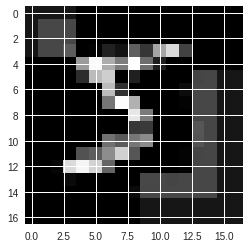

In [37]:
plt.imshow(maps[0][15].cpu().detach().numpy())

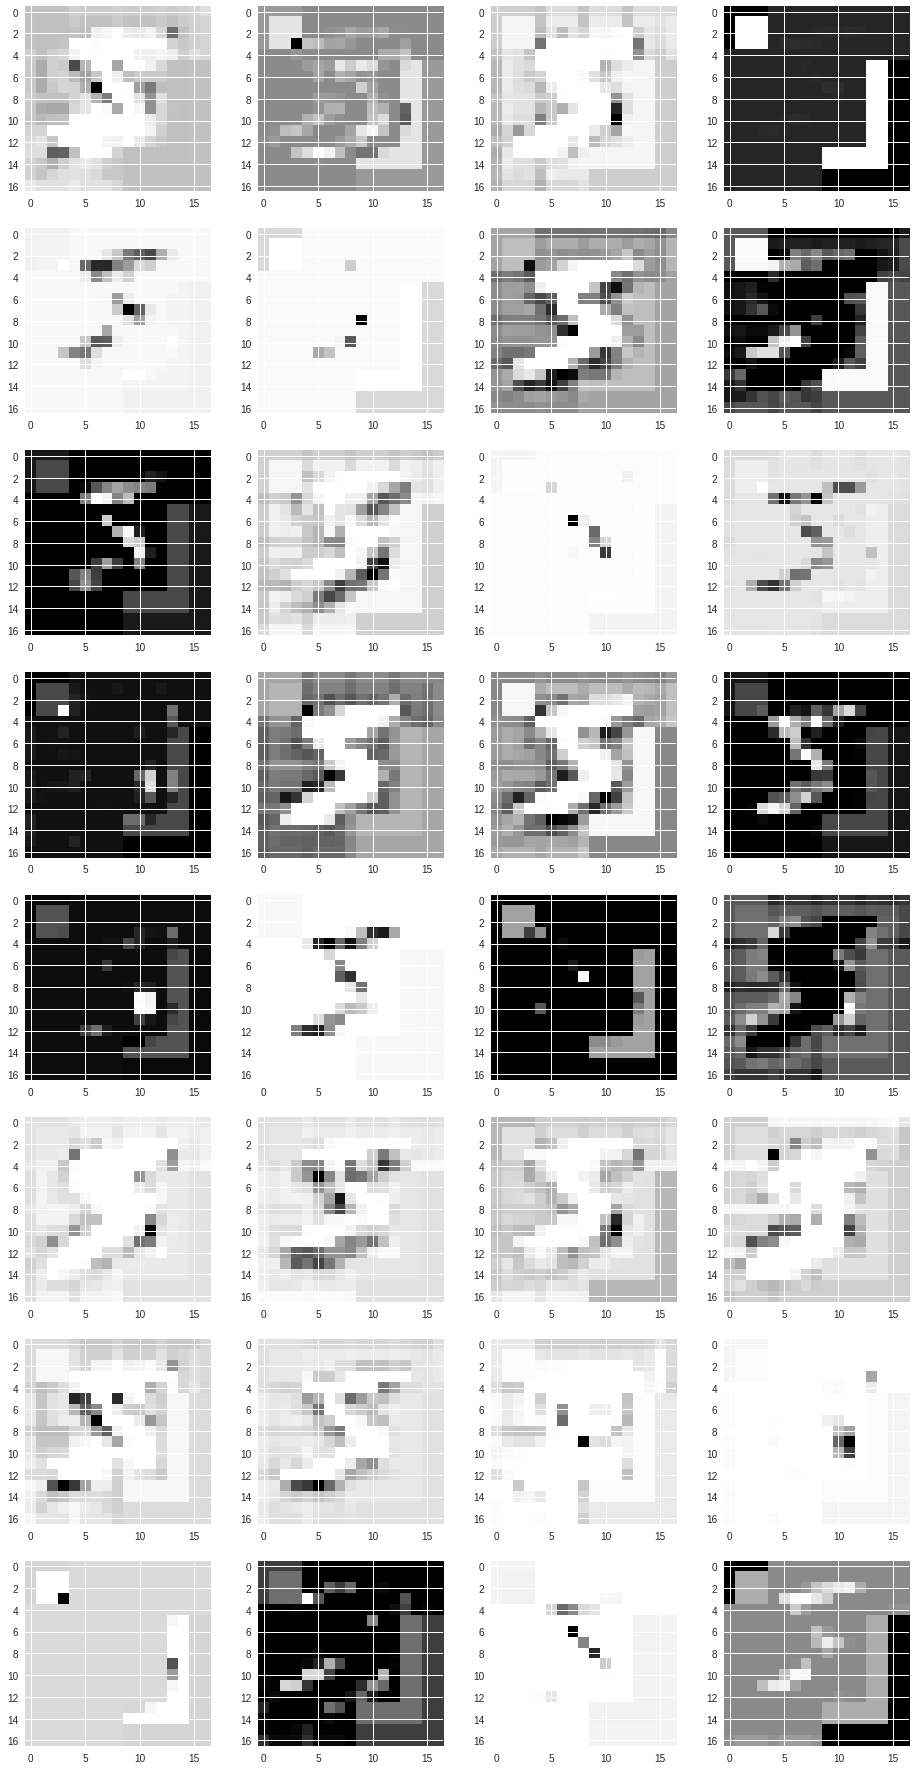

In [38]:
fig=plt.figure(figsize=(16, 32))
columns = 4
rows = 8
z =0
for i in range(1, columns*rows +1):
    img = maps[0][z].cpu().detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    z += 1
plt.show()

In [0]:
gs = [[list(i[0].size()), list(i[1].size())] for i in gradients]

In [184]:
gs[]

[[[16, 10], [16, 10]],
 [[16, 10], [16, 10]],
 [[16, 64, 20, 20], [16, 64, 10, 10]],
 [[16, 32, 20, 20], [16, 64, 20, 20]],
 [[16, 32, 20, 20], [16, 64, 20, 20]],
 [[53, 32, 5, 5], [54, 32, 5, 5]],
 [[16, 32, 15, 15], [16, 32, 15, 15]],
 [[16, 32, 30, 30], [16, 32, 15, 15]],
 [[16, 16, 30, 30], [16, 32, 30, 30]],
 [[16, 16, 30, 30], [16, 32, 30, 30]],
 [[140, 16, 5, 5], [141, 16, 5, 5]],
 [[16, 16, 28, 28], [16, 16, 28, 28]],
 [[16, 10], [16, 10]],
 [[16, 10], [16, 10]],
 [[16, 64, 20, 20], [16, 64, 10, 10]],
 [[16, 32, 20, 20], [16, 64, 20, 20]],
 [[16, 32, 20, 20], [16, 64, 20, 20]],
 [[55, 32, 5, 5], [56, 32, 5, 5]],
 [[16, 32, 15, 15], [16, 32, 15, 15]],
 [[16, 32, 30, 30], [16, 32, 15, 15]],
 [[16, 16, 30, 30], [16, 32, 30, 30]],
 [[16, 16, 30, 30], [16, 32, 30, 30]],
 [[150, 16, 5, 5], [151, 16, 5, 5]],
 [[16, 16, 28, 28], [16, 16, 28, 28]],
 [[16, 10], [16, 10]],
 [[16, 10], [16, 10]],
 [[16, 64, 20, 20], [16, 64, 10, 10]],
 [[16, 32, 20, 20], [16, 64, 20, 20]],
 [[16, 32, 20, 2

In [185]:
gradients[10]

[tensor([[[[ 5.9980e-04, -9.7689e-04, -4.7413e-04, -1.5796e-04,  1.6260e-04],
           [ 4.6087e-04, -8.0622e-05, -4.0753e-04, -6.1410e-08, -1.4955e-04],
           [ 8.1490e-04, -1.4287e-04, -6.4879e-05, -8.6229e-05, -1.6485e-04],
           [-2.3504e-04, -9.3926e-05,  4.2980e-04, -1.8540e-04,  1.0059e-04],
           [-1.1711e-04,  1.4957e-04, -2.7061e-04, -3.3048e-05,  3.3792e-05]],
 
          [[ 2.9563e-05, -3.8560e-04, -2.9804e-05, -2.9587e-04, -1.3189e-05],
           [ 2.1376e-04,  3.1170e-04,  3.8319e-04, -1.2853e-05,  1.5739e-04],
           [-2.7243e-04,  5.2100e-04, -3.8856e-04,  5.6791e-05,  2.4624e-04],
           [ 2.8226e-05, -6.2319e-05, -1.2919e-04, -1.6103e-04,  1.1363e-04],
           [ 4.3550e-06, -1.0212e-05,  2.6039e-04,  2.7897e-04,  9.5767e-06]],
 
          [[ 4.6742e-04, -7.2529e-04, -4.2498e-04, -2.0279e-04,  2.7860e-04],
           [ 6.8610e-04, -4.5957e-06, -3.9548e-04,  1.8699e-05, -6.8717e-04],
           [ 6.2745e-04, -6.2796e-04,  4.0117e-04, -5.2176